The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


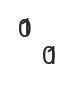

In [25]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

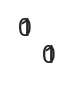

In [27]:
mpl.rcParams['figure.dpi'] = 180
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_sub = pd.read_csv('../data/cedar_subst_mut.csv')

In [4]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## reloading nnalign etc scores

In [6]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [7]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

### Merging w/ baseline scores

In [8]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [9]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

### quick roc check

In [16]:
cedar_related = pd.read_csv('../data/220920_cedar_related_scored.csv')

In [17]:
cedar_related_baseline = cedar.merge(cedar_related, left_on=['Peptide', 'HLA', 'trueHLA_EL_rank'],
                                     right_on = ['Peptide', 'HLA', 'trueHLA_EL_rank'],
                                     suffixes=('', '_delme')  # Left gets no suffix, right gets something identifiable
)
# Discard the columns that acquired a suffix
cedar_related_baseline = cedar_related_baseline[[c for c in cedar_related_baseline.columns if not c.endswith('_delme')]]
display(cedar_related_baseline.head()), len(cedar_related_baseline)

,Peptide,HLA,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trainset,Core,P1,Measure,nnalign_score,Peptide_x,Gap_pos,Gap_lgt,Insert_pos,Insert_lgt,Core+gap,P1_Rel,Peptide_y,MixMHCrank,PRIME_score,MixMHCallele,wild_type,wt_EL_rank,len_wt,mutation_type,mutation_position,anchor_mutation,mhc_anchor,wt_true,Related Object_Starting Position,Related Object_Ending Position,binder,delta_rank
0,AAAAAAQQIQV,HLA-B07:02,26.7692,0,8,11.9024,0.1632,27198675,AAAAAQIQV,AAAAAAQQIQV,Negative,11,0.0,5.2822,0.0166,HLA-A68:02,Negative,1,116.363636,-0.290909,0.818182,6.100000,0.004545,-0.675455,0.105455,-0.388182,cedar,AAAAAA,0,0.001,0.04789,AAAAAAQQIQV,0,0,0,0,AAAAAA,0.60,AAAAAAQQIQV,4.676,0.008733,B5601,AAAAAAQQLQV,25.5667,11,substitution,8,False,"0,1,3,10",True,157.0,167.0,Conserved,1.2025
1,AAAAQQIQV,HLA-B07:02,4.9092,0,8,0.3045,0.4709,27198675,AAAAQQIQV,AAAAQQIQV,Negative,9,0.0,0.1036,0.6567,HLA-C15:02,Negative,1,120.000000,0.046667,0.600000,6.100000,-0.027778,-0.525556,0.048889,-0.367778,cedar,AQQIQV,3,0.001,0.11765,AAAAQQIQV,0,0,0,0,AQQIQV,0.50,AAAAQQIQV,0.363,0.097263,C1203,AAAAQQLQV,4.7746,9,substitution,6,False,"1,8",True,159.0,167.0,Conserved,0.1346
2,AAAAQQIQV,HLA-A02:01,1.9555,0,8,0.3045,0.4709,27198675,AAAAQQIQV,AAAAQQIQV,Negative,9,0.0,0.1036,0.6567,HLA-C15:02,Negative,1,120.000000,0.046667,0.600000,6.100000,-0.027778,-0.525556,0.048889,-0.367778,cedar,AQQIQV,3,0.001,0.11765,AAAAQQIQV,0,0,0,0,AQQIQV,0.50,AAAAQQIQV,0.363,0.097263,C1203,AAAAQQLQV,2.2847,9,substitution,6,False,"1,3,8",True,159.0,167.0,Improved,-0.3292
3,AAFIWIISM,HLA-B35:01,1.3004,0,9,0.1502,0.6560,27198675,AAFIWIISM,AAFIWIISM,Negative,9,0.0,0.1756,0.3961,HLA-C12:03,Negative,1,152.222222,-2.515556,2.233333,6.100000,0.830000,0.034444,-0.400000,-0.330000,cedar,AAFIWI,0,0.001,0.37003,AAFIWIISM,0,0,0,0,AAFIWI,0.25,AAFIWIISM,0.001,0.331801,C1203,AAFIWIISM,1.3004,9,same,-1,False,"1,8",True,161.0,169.0,Conserved,0.0000
4,AAHFTVLLY,HLA-A11:01,0.4196,0,3,0.1083,0.6509,31511069,AAHFTVLLY,AAHFTVLLY,Negative,9,0.0,0.0256,0.8170,HLA-A30:02,Negative,1,141.111111,-1.456667,1.444444,7.542349,0.571111,-0.022222,-0.167778,-0.212222,cedar,HFTVLL,2,0.001,0.31177,AAHFTVLLY,0,0,0,0,HFTVLL,0.70,AAHFTVLLY,0.011,0.285331,A2902,AAHFTALLY,0.5881,9,substitution,5,False,"0,1,8",True,1949.0,1957.0,Improved,-0.1685


(None, 3242)

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

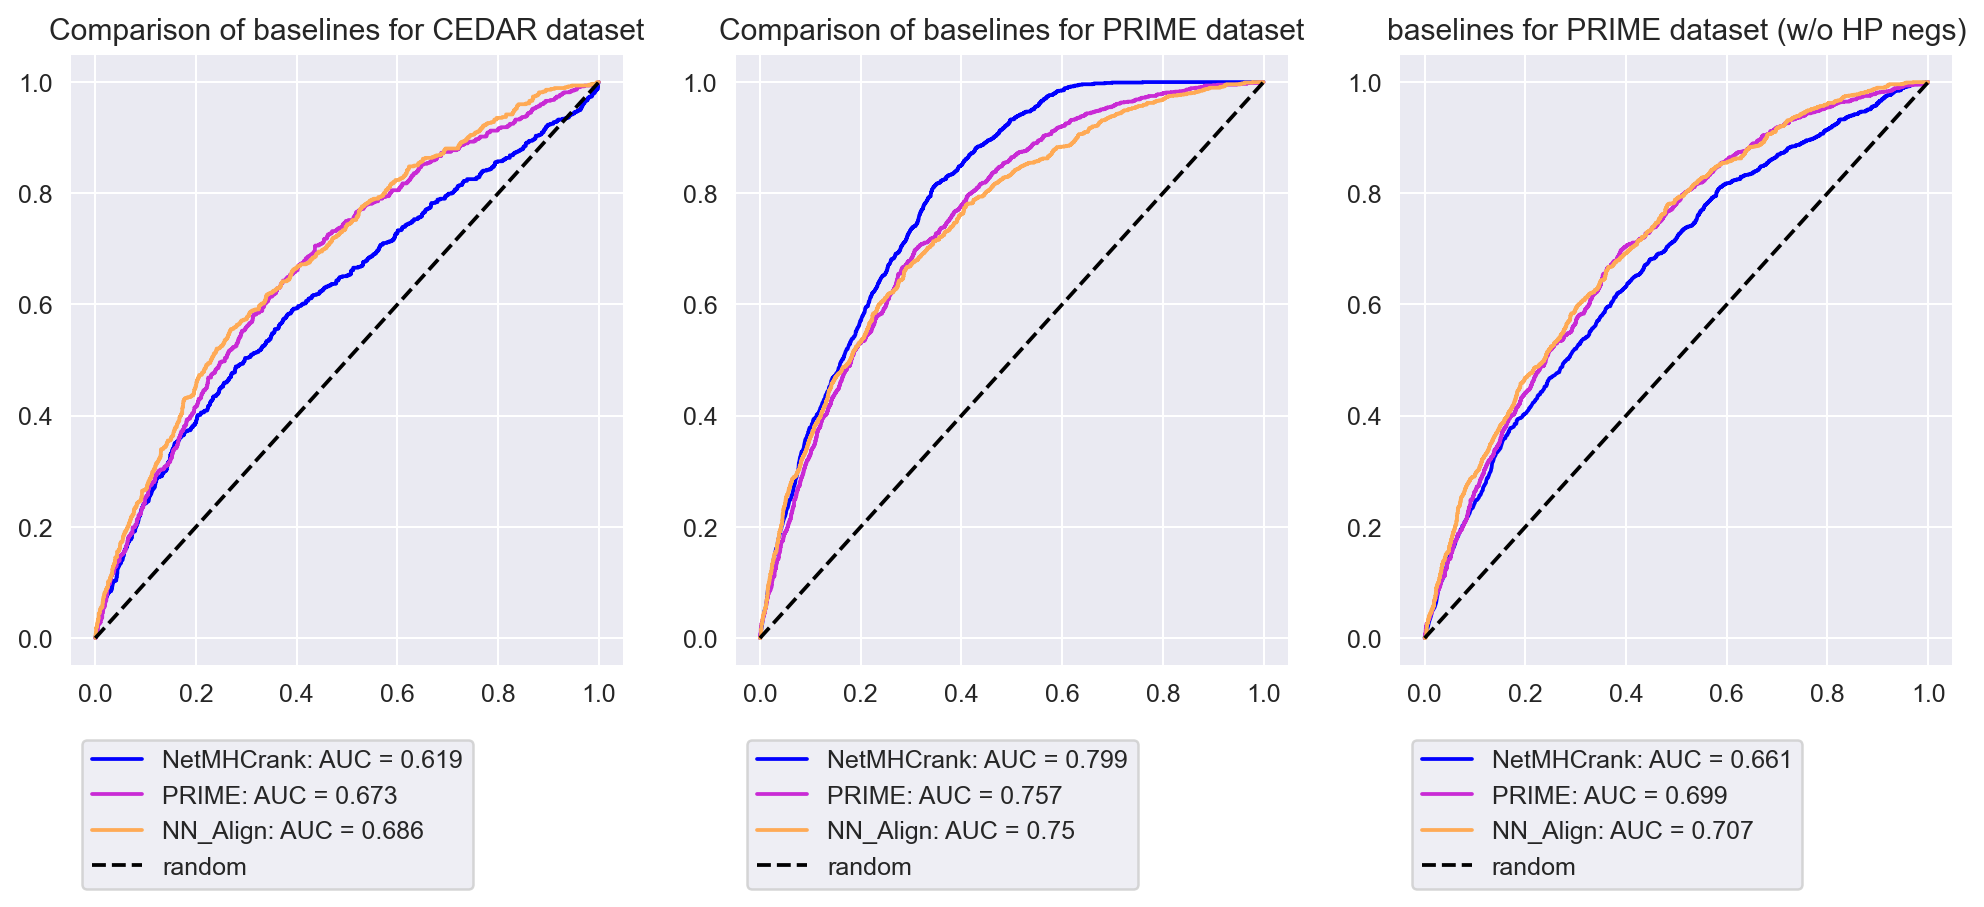

In [18]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)

a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

In [19]:
cedar_related_baseline.query('mutation_type!="substitution"').groupby(['anchor_mutation','binder']).count()

Peptide  HLA  trueHLA_EL_rank  agg_label  fold  \
anchor_mutation binder                                                      
False           Conserved      130  130              130        130   130   
                Improved        45   45               45         45    45   

                           BA_rank  BA_score  PMIDs  core  icore  label  len  \
anchor_mutation binder                                                         
False           Conserved      130       130    130   130    130    130  130   
                Improved        45        45     45    45     45     45   45   

                           percentage_pos  pred_EL_rank  pred_EL_score  \
anchor_mutation binder                                                   
False           Conserved             130           130            130   
                Improved               45            45             45   

                           pred_HLA  responses  total_count  aliphatic_index  \
anchor_mutation binder                                                         
False           Conserved       130        130          130              130   
                Improved         45         45           45               45   

                           boman  hydrophobicity  isoelectric_point  VHSE1  \
anchor_mutation binder                                                       
False           Conserved    130             130                130    130   
                Improved      45              45                 45     45   

                           VHSE3  VHSE7  VHSE8  trainset  Core   P1  Measure  \
anchor_mutation binder                                                         
False           Conserved    130    130    130       130   130  130      130   
                Improved      45     45     45        45    45   45       45   

                           nnalign_score  Peptide_x  Gap_pos  Gap_lgt  \
anchor_mutation binder                                                  
False           Conserved            130        130      130      130   
                Improved              45         45       45       45   

                           Insert_pos  Insert_lgt  Core+gap  P1_Rel  \
anchor_mutation binder                                                
False           Conserved         130         130       130     130   
                Improved           45          45        45      45   

                           Peptide_y  MixMHCrank  PRIME_score  MixMHCallele  \
anchor_mutation binder                                                        
False           Conserved        130         130          130           130   
                Improved          45          45           45            45   

                           wild_type  wt_EL_rank  len_wt  mutation_type  \
anchor_mutation binder                                                    
False           Conserved        130         130     130            130   
                Improved          45          45      45             45   

                           mutation_position  mhc_anchor  wt_true  \
anchor_mutation binder                                              
False           Conserved                130         130      130   
                Improved                  45          45       45   

                           Related Object_Starting Position  \
anchor_mutation binder                                        
False           Conserved                               130   
                Improved                                 45   

                           Related Object_Ending Position  delta_rank  
anchor_mutation binder                                                 
False           Conserved                             130         130  
                Improved                               45          45

### Baseline fct def

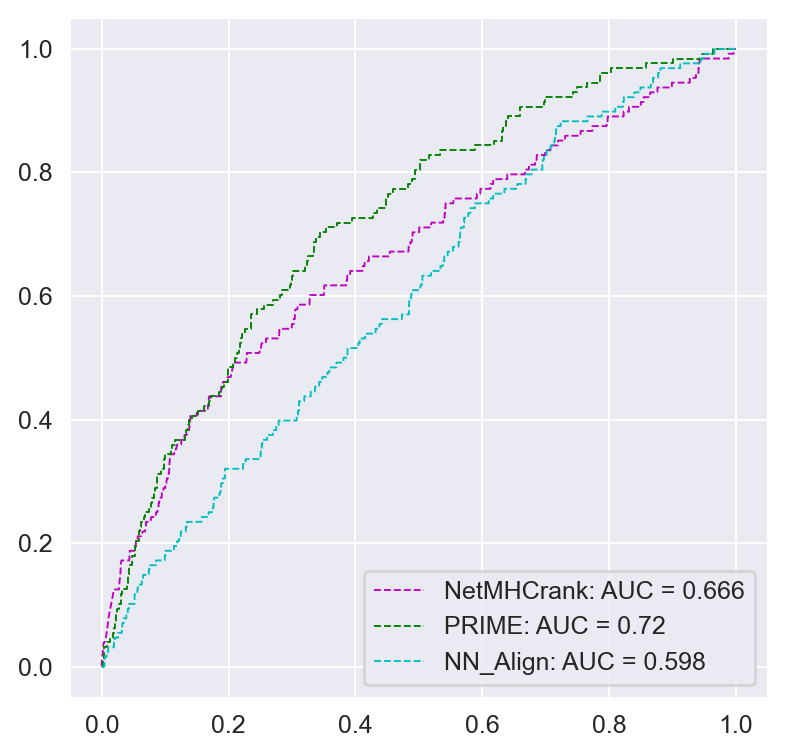

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score
not_in = ['Random', 'Calis', 'Dengue']
# PLOT BASELINE FUNCTIONS
def plot_baseline_roc(axis, dataset, neoepi_only=True):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
        
    elif dataset=='prime':
        tmp = prime.query('StudyOrigin not in @not_in') if neoepi_only else prime
        tmp = tmp.query('HLA in @HLAS')
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='--', lw=0.75, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='--', lw=0.75, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='--', lw=0.75, color='c')

    
def plot_baseline_roc_related(axis, dataset, binder, anchor_mutation):
    if dataset == 'cedar':
        tmp = cedar_related_baseline.query('binder==@binder and anchor_mutation==@anchor_mutation')
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['agg_label'].values,  -1* tmp['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(tmp['agg_label'].values, -1*tmp['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['agg_label'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(tmp['agg_label'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['agg_label'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['agg_label'].values, tmp['nnalign_score'].values)
    
    elif dataset=='prime':
        tmp = tmp_prime.query('binder==@binder and anchor_mutation==@anchor_mutation')
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['agg_label'].values,  -1* tmp['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(tmp['agg_label'].values, -1*tmp['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['agg_label'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(tmp['agg_label'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['agg_label'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['agg_label'].values, tmp['nnalign_score'].values)

    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='--', lw=0.75, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='--', lw=0.75, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='--', lw=0.75, color='c')
    
    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')
    
f,a = plt.subplots(1,1, figsize=(5,5))
plot_baseline_roc(a, 'prime', neoepi_only=True)
a.legend(loc='lower right')

# Various checks

In [221]:
dataset = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
gb = dataset.groupby(['anchor_mutation', 'binder', 'agg_label']).agg(count=('Peptide','count'))
gb['proportion'] = gb.groupby(['anchor_mutation', 'binder']).apply(lambda x: x/np.sum(x))
gb

count  proportion
anchor_mutation binder    agg_label                   
False           Conserved 0           1191    0.788742
                          1            319    0.211258
                Improved  0            155    0.807292
                          1             37    0.192708
True            Conserved 0            701    0.867574
                          1            107    0.132426
                Improved  0            394    0.753346
                          1            129    0.246654

In [222]:
features = [x for x in df.columns if 'delta_' in x or 'ratio' in x or x == 'anchor_mutation' or x=='mutation_score']
features

['EL_ratio',
 'anchor_mutation',
 'delta_VHSE1',
 'delta_VHSE3',
 'delta_VHSE7',
 'delta_VHSE8',
 'delta_aliphatic_index',
 'delta_boman',
 'delta_hydrophobicity',
 'delta_isoelectric_point',
 'delta_rank',
 'mutation_score']

In [126]:
print('Normal KL Weighting for HLA A0201, Length 9\n\t', [x.round(3) for x in 1 - ics_kl[9]['HLA-A0201'][0.25]])

print('"Inverted" KL Weighting for HLA A0201, Length 9\n\t', [x.round(3) for x in ics_kl[9]['HLA-A0201'][0.25]])
print('Anchor positions\n\t', [x>.1617 for x in ics_kl[9]['HLA-A0201'][0.25]])

Normal KL Weighting for HLA A0201, Length 9
	 [0.883, 0.335, 0.921, 0.838, 0.958, 0.878, 0.933, 0.924, 0.434]
"Inverted" KL Weighting for HLA A0201, Length 9
	 [0.117, 0.665, 0.079, 0.162, 0.042, 0.122, 0.067, 0.076, 0.566]
Anchor positions
	 [False, True, False, True, False, False, False, False, True]


# Model & Runs

In [215]:
x=encode_batch(df.query('len==9').sample(100)['Peptide'].values, 9, 'blosum', blosum_matrix=BL62_VALUES)
x.shape

torch.Size([100, 9, 20])

In [206]:
class Standardizer(NetParent):
    def __init__(self):
        self.mu = 0
        self.sigma = 1
        self.fitted = False
    
    def fit(x_train):
        assert self.training, 'Can not fit while in eval mode. Please set model to training mode'
        self.mu = x_train.mean(axis=0)
        self.sigma = x_train.std(axis=0)
        self.fitted = True
    
    def forward(x):
        assert self.fitted, 'Standardizer has not been fitted. Please fit to x_train'
        return (x - self.mu) / self.sigma
        
        

class ConvBlock(NetParent):
    def __init__(self, input_length = 12, n_filters=10, #maxpool_ks = 4, n_embedded = 30, 
                 act=nn.ReLU()):
        super(ConvBlock, self).__init__()
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=n_filters, kernel_size=3, padding='same')
        self.conv5 = nn.Conv1d(in_channels=20, out_channels=n_filters, kernel_size=5, padding='same')
        self.conv7 = nn.Conv1d(in_channels=20, out_channels=n_filters, kernel_size=7, padding='same')
        # self.maxpool = nn.MaxPool1d(kernel_size=maxpool_ks)
        self.act = act
        # 3* n_filters because 3 conv layers
        # FC_out here may be unecessary when using torch.max instead of maxpool with kernel size of 4
        self.fc_out = nn.Linear(3*n_filters, n_embedded) 
        
    def reshape_input(self, x):
        in_channels = self.conv3.in_channels
        assert (len(x.shape) == 3 and x.shape[-1] == in_channels), f'Provided input of shape {x.shape} has the wrong dimensions.\n'\
                                 f'It should have 3 dimensions and have in_channels={in_channels} for the last dimension.'
        if type(x) == np.ndarray:
            return torch.from_numpy(np.transpose(x, [0, 2, 1])).to(self.conv3.weight.device)
        elif type(torch.Tensor):
            return torch.permute(x, [0, 2, 1])
        
    def forward(self, x):
        x = self.reshape_input(x)
        conv3 = torch.max(self.act(self.conv3(x)), 2)[0]
        conv5 = torch.max(self.act(self.conv5(x)), 2)[0]
        conv7 = torch.max(self.act(self.conv7(x)), 2)[0]
        out = torch.cat([conv3, conv5, conv7], 1)#.flatten(start_dim=1, end_dim=2)
        out = self.fc_out(out)
        return out

class DICNN(NetParent):
    
    def __init__(self, input_length=12, n_filters=10, # maxpool_ks=4, n_embedded = 30,
                 n_hidden=32, n_props=10, act=nn.ReLU()):
        super(DICNN, self).__init__()
        self.conv_block = ConvBlock(n_filters)
        self.act = act
        self.dropout = nn.Dropout(0.3)
        self.batchnorm = nn.BatchNorm1d(n_hidden)
        self.fc_in = nn.Linear(2*3*n_filters + n_props, n_hidden)
        self.fc_out = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x_mut, x_wt, x_props):
        conv_mut = self.conv_block(x_mut)
        conv_wt = self.conv_block(x_wt)
        x = torch.cat([conv_mut, conv_wt, x_props], dim=1)
        x = self.dropout(self.batchnorm(self.act(self.fc_in(x))))
        out = self.sigmoid(self.fc_out(x))
        return out
    
class NetWrapper(NetParent):
    def __init__(self, input_length, n_filters, n_hidden, n_props, act=nn.ReLU()):
        super(NetWrapper, self).__init__()
        self.standardizer = Standardizer()
        self.dicnn = DICNN(input_length, n_filters, n_hidden, n_props, act)
    
    def forward(self, x_mut, x_wt, x_props):
        x_props = self.standardizer(x_props)
        output = self.dicnn(x_mut, x_wt, x_props)
        return output
    